In [ ]:
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*

     |████████████████████████████████| 80 kB 3.3 MB/s 
     |████████████████████████████████| 245 kB 4.2 MB/s 
     |████████████████████████████████| 102 kB 51.4 MB/s 
     |████████████████████████████████| 62 kB 792 kB/s 
     |████████████████████████████████| 76 kB 4.3 MB/s 
     |████████████████████████████████| 675 kB 49.3 MB/s 
     |████████████████████████████████| 3.1 MB 42.8 MB/s 
     |████████████████████████████████| 812 kB 70.4 MB/s 
     |████████████████████████████████| 28.5 MB 46 kB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=d4579cb8b2866bc190b9212c18615e5f8b73334bfae0a335abff7273d721b528
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=6ad9d740919cc3050fb35d2fc45a48207e4a9f4c1136586f6881db5c7b7282e3
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e29753

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.options.display.max_rows = 1000

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ImportError: ignored

# Decision Trees

- clean data with **outliers and missing values**
- use scikit-learn for **decision trees**
- get and interpret **feature importances** of a tree-based model
- understand why decision trees are useful to model 

# I. Wrangle Data

### Import data



In [ ]:
train['status_group'].value_counts()

In [ ]:
train_data = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
train = pd.merge(train_data,train_labels)

def wrangle(df):

  # Set the index to 'id'
  df.set_index('id',inplace=True)

  # Drop columns that have high cardinality
  cols_to_drop = [col for col in df.select_dtypes("object") if df[col].nunique() >100]
  df.drop(columns=cols_to_drop,inplace = True)

  # Drop columns that are constant
  df.drop(columns='recorded_by', inplace =True)

  # Drop column with zeros
  df.drop(columns='num_private', inplace=True)

  return df

In [ ]:
df=wrangle(train)

In [ ]:
Report = ProfileReport(train,minimal=True).to_notebook_iframe()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             47520 non-null  float64
 1   gps_height             47520 non-null  int64  
 2   longitude              47520 non-null  float64
 3   latitude               47520 non-null  float64
 4   basin                  47520 non-null  object 
 5   region                 47520 non-null  object 
 6   region_code            47520 non-null  int64  
 7   district_code          47520 non-null  int64  
 8   population             47520 non-null  int64  
 9   public_meeting         44831 non-null  object 
 10  scheme_management      44418 non-null  object 
 11  permit                 45081 non-null  object 
 12  construction_year      47520 non-null  int64  
 13  extraction_type        47520 non-null  object 
 14  extraction_type_group  47520 non-null  object 
 15  

### EDA

In [ ]:
train['status_group'].value_counts()

# II. Split Data

In [ ]:
target = 'status_group'

y = df[target]
X = df.drop(columns=target)

## Split TV from FM

In [ ]:
df.loc[df['status_group']=='functional','labels']=1
df.loc[df['status_group']!='functional','labels']=0

In [ ]:
df.drop(columns='status_group',inplace=True)

In [ ]:
df.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,labels
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454,50.0,2092,35.426020,-4.227446,Internal,Manyara,21,1,160,True,Water Board,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,1.0
510,0.0,0,35.510074,-5.724555,Internal,Dodoma,1,6,0,True,VWC,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,1.0
14146,0.0,0,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6,0,True,VWC,False,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,0.0
47410,0.0,0,34.060484,-8.830208,Rufiji,Mbeya,12,7,0,True,VWC,True,0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,0.0
1288,300.0,1023,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1,120,True,VWC,True,1997,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other,0.0


## Training-Validation Split

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# III. Establish Baseline

- Is this a *regression* or a *classification* problem?
- Because it's a **classification** problem, we need to calculate baseline accuracy based on our majority class. 

In [ ]:
# Baseline prediciton

print('Baseline Accuracy:',y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5440867003367004


# IV. Build Model(s)

- Encoder for categorical features.
- Imputer for missing values.
- `StandardScaler` for `LogisticRegression`

**First Model:** Logistic Regression

In [ ]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   

**Second Model:** Decision Tree Classifier

In [ ]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=15,random_state=42)
)

model_dt.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity',
                                      'quantity_group', 'source', 'source_type',
                                      'source_class'...
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                             

**Interlude: How does a tree model work?**

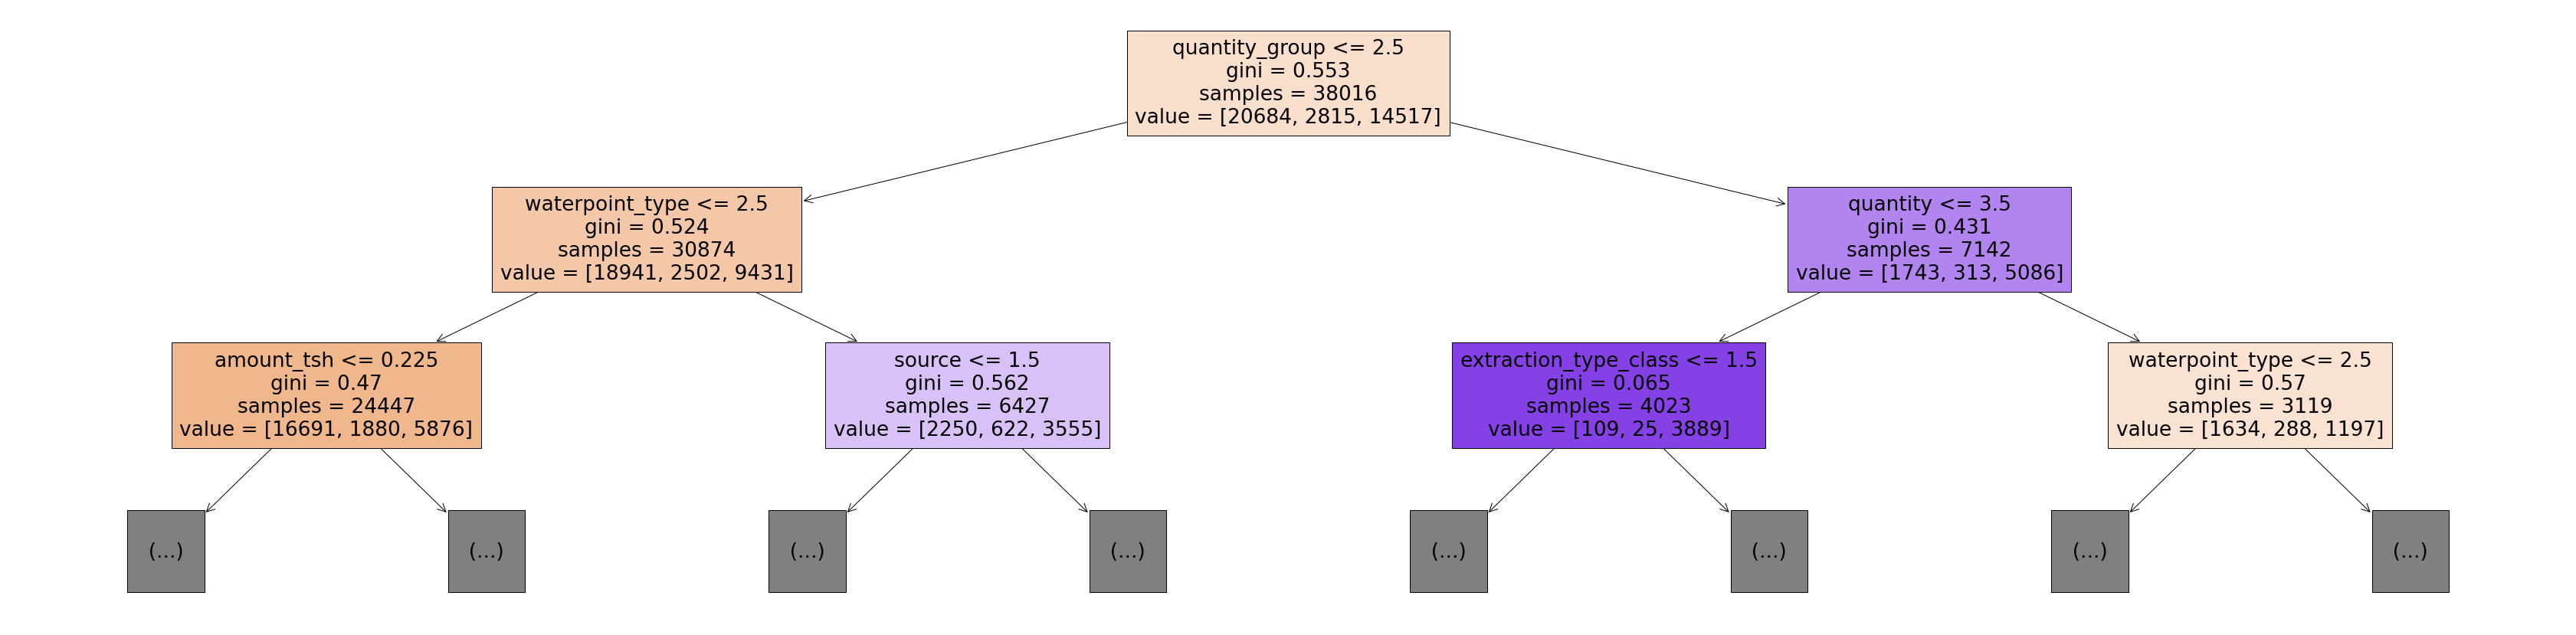

In [ ]:
plt.figure(figsize=(60,15))
plot_tree(model_dt.named_steps['decisiontreeclassifier'],
          max_depth=2,
          feature_names=X_train.columns,
          filled=True);

# V. Check Metrics

In [ ]:
print('model_lr accuracy score for training', accuracy_score(y_train, model_lr.predict(X_train)))
print('model_lr accuracy score for val', accuracy_score(y_val, model_lr.predict(X_val)))

model_lr accuracy score for training 0.7337699915824916
model_lr accuracy score for val 0.7359006734006734


In [ ]:
print('model_dt accuracy score for training', accuracy_score(y_train, model_dt.predict(X_train)))
print('model_dt accuracy score for val', accuracy_score(y_val, model_dt.predict(X_val)))

model_dt accuracy score for training 0.8596380471380471
model_dt accuracy score for val 0.7700968013468014


# VI. Tune Model

Let's look at the hyperparameter `max_depth`

In [ ]:
depths = range(5,20,2)

In [ ]:
list(depths)

[5, 7, 9, 11, 13, 15, 17, 19]

In [ ]:
train_acc = []
val_acc = []

for depth in depths:
  model_pt = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      DecisionTreeClassifier(max_depth=depth,random_state=42)
  )
  model_pt.fit(X_train,y_train)
  train_acc.append(model_pt.score(X_train,y_train))
  val_acc.append(model_pt.score(X_val,y_val))

In [ ]:
train_acc

[0.7126736111111112,
 0.7327704124579124,
 0.7587857744107744,
 0.7892203282828283,
 0.8225484006734006,
 0.8596380471380471,
 0.8944391835016835,
 0.9241109006734006]

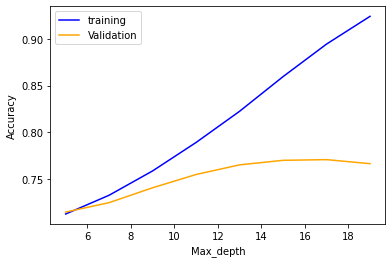

In [ ]:
plt.plot(depths,train_acc,color='blue',label='training')
plt.plot(depths,val_acc,color='orange',label='Validation')
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

# VII. Communicate Results


### Gini importance

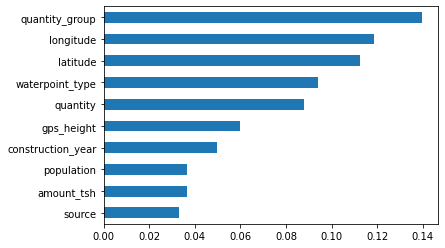

In [ ]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini,index=features).sort_values(key=abs).tail(10).plot(kind='barh');